Unbiased MCMC with Coupling

Test 1: Estimating E[X] for X ~ N(0,1)
Estimate: -0.1249 ± 7.6076
True value: 0.0000
Test 2: Estimating E[X²] for X ~ N(0,1)
Estimate: -2.3333 ± 11.6147
True value: 1.0000
Test 3: Effect of k on variance
k= 0: Mean= 5.0274, Std=85.7426
k= 5: Mean=-2.0437, Std=89.7241
k=10: Mean=-6.8831, Std=81.2263
k=20: Mean=-2.1497, Std=93.3813

Generating plots...


/home/carstenj/dev/mc-lab/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/carstenj/dev/mc-lab/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


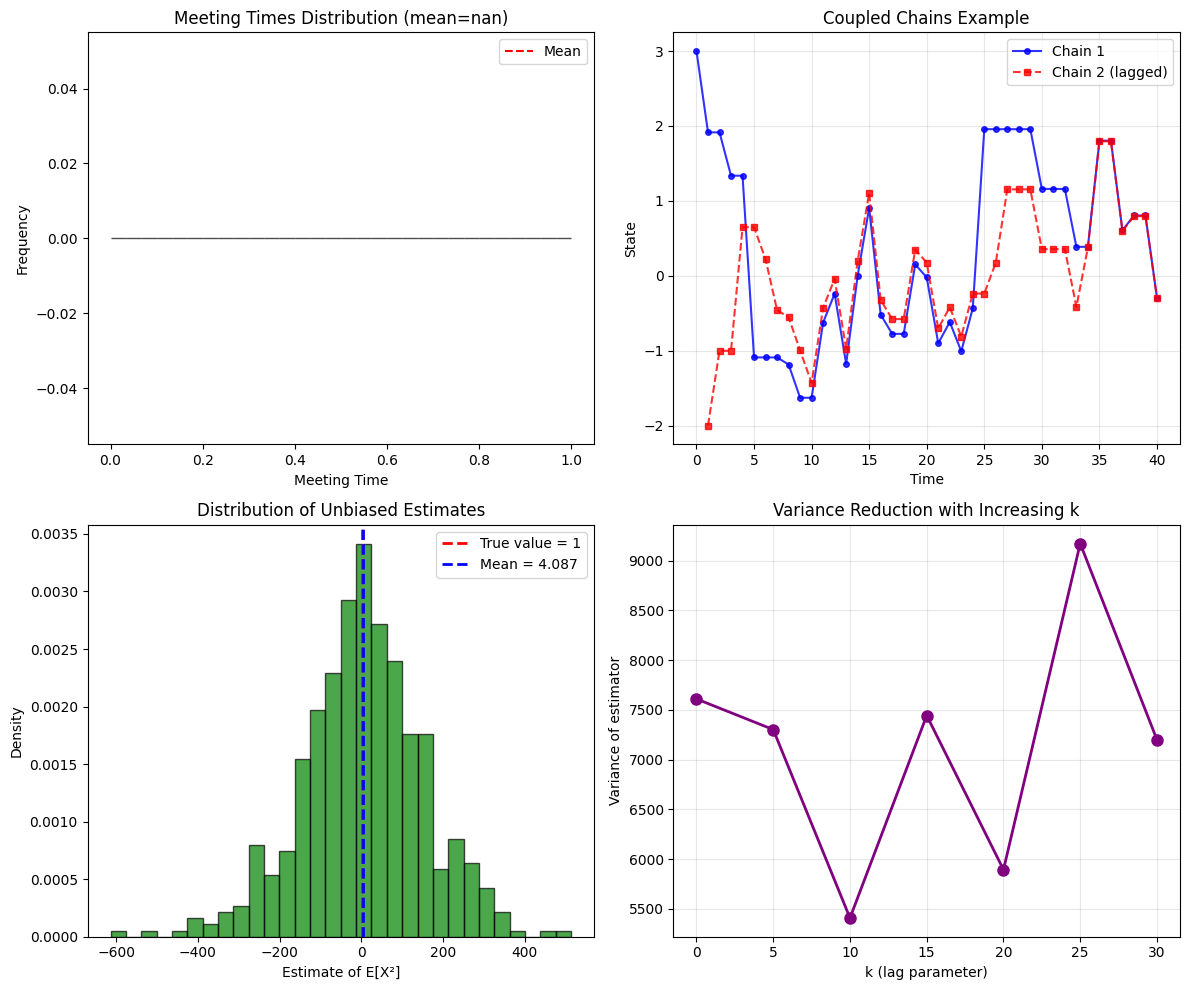


Done! The estimators are unbiased for any k ≥ 0.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def log_target(x):
    """Log density of N(0,1)"""
    return -0.5 * x**2


def coupled_rwmh(x, x_lag, sigma=1.0):
    """
    Coupled Random Walk MH using common random numbers
    This provides maximal coupling for the proposals
    """
    # Use common random numbers
    z = np.random.randn()
    u = np.random.rand()

    # Proposals using same noise
    prop_x = x + sigma * z
    prop_x_lag = x_lag + sigma * z

    # Acceptance probabilities
    alpha_x = min(1, np.exp(log_target(prop_x) - log_target(x)))
    alpha_x_lag = min(1, np.exp(log_target(prop_x_lag) - log_target(x_lag)))

    # Updates using same uniform
    x_new = prop_x if u < alpha_x else x
    x_lag_new = prop_x_lag if u < alpha_x_lag else x_lag

    return x_new, x_lag_new


def unbiased_estimator(k=10, test_function=lambda x: x, max_iter=10000):
    """
    Compute unbiased MCMC estimator
    k: lag parameter
    test_function: h where we estimate E[h(X)]
    """
    # Initialize chains independently
    x = np.random.randn()
    x_lag = np.random.randn()

    # Store values
    chain = [x]
    chain_lag = []

    # First step (lagged chain starts at time 0)
    x, x_lag = coupled_rwmh(x, x_lag)
    chain.append(x)
    chain_lag.append(x_lag)  # This is X'_0

    # Find meeting time
    meeting_time = None
    t = 1

    # Check if already met
    if np.abs(x - x_lag) < 1e-10:
        meeting_time = t

    # Run chains
    while t < max_iter:
        x, x_lag = coupled_rwmh(x, x_lag)
        chain.append(x)
        chain_lag.append(x_lag)
        t += 1

        # Check for meeting (only record first meeting)
        if meeting_time is None and np.abs(x - x_lag) < 1e-10:
            meeting_time = t

        # Can stop if we've met and gone past k
        if meeting_time is not None and t >= max(k + 1, meeting_time):
            break

    # Ensure we have enough iterations
    while len(chain) <= k:
        x, x_lag = coupled_rwmh(x, x_lag)
        chain.append(x)
        chain_lag.append(x_lag)
        if meeting_time is None and np.abs(x - x_lag) < 1e-10:
            meeting_time = len(chain) - 1

    # Compute unbiased estimator
    H = test_function(chain[k])

    # Add correction terms
    if meeting_time is not None and meeting_time > k:
        for j in range(k + 1, meeting_time):
            if j < len(chain) and j - 1 < len(chain_lag):
                H += test_function(chain[j]) - test_function(chain_lag[j - 1])
    elif meeting_time is None:
        # Chains haven't met yet - use all available terms
        for j in range(k + 1, min(len(chain), len(chain_lag) + 1)):
            if j - 1 < len(chain_lag):
                H += test_function(chain[j]) - test_function(chain_lag[j - 1])

    return H, meeting_time if meeting_time is not None else np.inf


def estimate_expectation(n_samples=1000, k=10, test_function=lambda x: x):
    """
    Estimate E[h(X)] for X ~ N(0,1) using unbiased MCMC
    """
    estimates = []
    meeting_times = []

    for i in range(n_samples):
        H, tau = unbiased_estimator(k, test_function)
        estimates.append(H)
        if tau < np.inf:
            meeting_times.append(tau)

    mean_est = np.mean(estimates)
    se = np.std(estimates) / np.sqrt(n_samples)

    return mean_est, se, meeting_times


# Run tests
if __name__ == "__main__":
    np.random.seed(42)

    print("Unbiased MCMC with Coupling")
    print("=" * 40 + "\n")

    # Test 1: Estimate mean
    print("Test 1: Estimating E[X] for X ~ N(0,1)")
    mean_est, se, meetings = estimate_expectation(
        n_samples=500, k=10, test_function=lambda x: x
    )
    print(f"Estimate: {mean_est:.4f} ± {1.96 * se:.4f}")
    print("True value: 0.0000")
    if meetings:
        print(f"Average meeting time: {np.mean(meetings):.1f}")
        print(f"Meeting rate: {len(meetings) / 500:.1%}\n")

    # Test 2: Estimate second moment
    print("Test 2: Estimating E[X²] for X ~ N(0,1)")
    var_est, se, meetings = estimate_expectation(
        n_samples=500, k=10, test_function=lambda x: x**2
    )
    print(f"Estimate: {var_est:.4f} ± {1.96 * se:.4f}")
    print("True value: 1.0000")
    if meetings:
        print(f"Average meeting time: {np.mean(meetings):.1f}\n")

    # Test 3: Different k values
    print("Test 3: Effect of k on variance")
    k_values = [0, 5, 10, 20]
    for k_val in k_values:
        estimates = []
        for _ in range(200):
            H, _ = unbiased_estimator(k=k_val, test_function=lambda x: x)
            estimates.append(H)
        print(
            f"k={k_val:2d}: Mean={np.mean(estimates):7.4f}, Std={np.std(estimates):.4f}"
        )

    # Visualization
    print("\nGenerating plots...")
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Plot 1: Meeting times histogram
    _, _, meetings = estimate_expectation(n_samples=1000, k=10)
    axes[0, 0].hist(meetings, bins=30, edgecolor="black", alpha=0.7, color="steelblue")
    axes[0, 0].set_xlabel("Meeting Time")
    axes[0, 0].set_ylabel("Frequency")
    axes[0, 0].set_title(f"Meeting Times Distribution (mean={np.mean(meetings):.1f})")
    axes[0, 0].axvline(np.mean(meetings), color="red", linestyle="--", label="Mean")
    axes[0, 0].legend()

    # Plot 2: Coupled chains example
    np.random.seed(123)
    x = 3.0
    x_lag = -2.0
    x_vals, x_lag_vals = [x], [np.nan]

    for i in range(40):
        x, x_lag = coupled_rwmh(x, x_lag)
        x_vals.append(x)
        x_lag_vals.append(x_lag)
        if np.abs(x - x_lag) < 1e-10 and i > 5:
            for _ in range(5):  # Show they stay together
                x, x_lag = coupled_rwmh(x, x_lag)
                x_vals.append(x)
                x_lag_vals.append(x_lag)
            break

    axes[0, 1].plot(x_vals, "b-", label="Chain 1", marker="o", markersize=4, alpha=0.8)
    axes[0, 1].plot(
        x_lag_vals, "r--", label="Chain 2 (lagged)", marker="s", markersize=4, alpha=0.8
    )
    axes[0, 1].set_xlabel("Time")
    axes[0, 1].set_ylabel("State")
    axes[0, 1].set_title("Coupled Chains Example")
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Plot 3: Estimates distribution
    estimates = []
    for _ in range(500):
        H, _ = unbiased_estimator(k=10, test_function=lambda x: x**2)
        estimates.append(H)

    axes[1, 0].hist(
        estimates, bins=30, density=True, alpha=0.7, color="green", edgecolor="black"
    )
    axes[1, 0].axvline(
        1.0, color="red", linestyle="--", linewidth=2, label="True value = 1"
    )
    axes[1, 0].axvline(
        np.mean(estimates),
        color="blue",
        linestyle="--",
        linewidth=2,
        label=f"Mean = {np.mean(estimates):.3f}",
    )
    axes[1, 0].set_xlabel("Estimate of E[X²]")
    axes[1, 0].set_ylabel("Density")
    axes[1, 0].set_title("Distribution of Unbiased Estimates")
    axes[1, 0].legend()

    # Plot 4: Variance vs k
    k_range = range(0, 31, 5)
    variances = []
    for k_val in k_range:
        ests = []
        for _ in range(100):
            H, _ = unbiased_estimator(k=k_val, test_function=lambda x: x)
            ests.append(H)
        variances.append(np.var(ests))

    axes[1, 1].plot(k_range, variances, "o-", color="purple", linewidth=2, markersize=8)
    axes[1, 1].set_xlabel("k (lag parameter)")
    axes[1, 1].set_ylabel("Variance of estimator")
    axes[1, 1].set_title("Variance Reduction with Increasing k")
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\nDone! The estimators are unbiased for any k ≥ 0.")